SRAG 2021 e 2022 - Severe Acute Respiratory Syndrome Database

Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.feature_selection import chi2
import scipy.stats as stats
import seaborn as sn

Datasets

In [2]:
df_original = pd.read_csv('df_preprocessed.csv', delimiter=',')

In [36]:
df = df_original.copy(deep = True)
df.drop(columns=['Unnamed: 0'], inplace= True)

CONSTANTS

In [37]:
FAIXA_ETARIA = ['0-19', '20-24', '25-29', '30-34', '35-39', '40+']

FAIXA_RACA = ['White','Black','Others']
DIC_RACA = {1: 'White', 2: 'Black', 3: 'Others', 4: 'Others', 5: 'Others', 9: 'Ignored'}

FAIXA_ESCOLARIDADE = ['None or Primary incomplete', 'Primary', 'Secondary','College or more']
DIC_ESCOLARIDADE = {0: 'None or Primary incomplete', 1: 'None or Primary incomplete', 2: 'Primary', 3: 'Secondary', 4: 'College or more', 5: 'Ignored', 9: 'Ignored'}

FAIXA_GRAVIDEZ = ['First trimester','Second trimester','Third trimester','Gestation period ignored', 'Puerpera']
DICT_GRAVIDEZ = {1: 'First trimester', 2: 'Second trimester',3: 'Third trimester', 4: 'Gestation period ignored', 5 : 'Puerpera'}

DICT_VACINA = {1: 'at least 1 dose', 2: 'Unvaccinated', 9: 'Ignored'}
FAIXA_VACINA = ['at least 1 dose','Unvaccinated']

FAIXA_REGIAO = ['North','Northeast','Southeast','South','Midwest']

DICT_PADRAO = {1: 'Yes', 2: 'Not', 9: 'Ignored'}
FAIXA_PADRAO = ['Yes','Not']

Mapping dictionaries

In [38]:
df['CS_RACA'] = df['CS_RACA'].map(DIC_RACA)
df['CS_ESCOL_N'] = df['CS_ESCOL_N'].map(DIC_ESCOLARIDADE)
df['GRAVIDEZ'] = df['GRAVIDEZ'].map(DICT_GRAVIDEZ)
df['VACINA_COV'] = df['VACINA_COV'].map(DICT_VACINA)

df['CARDIOPATI'] = df['CARDIOPATI'].map(DICT_PADRAO)
df['RENAL'] = df['RENAL'].map(DICT_PADRAO)
df['ASMA'] = df['ASMA'].map(DICT_PADRAO)
df['DIABETES'] = df['DIABETES'].map(DICT_PADRAO)


Other_diseases = ['OUT_MORBI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'OBESIDADE']

for column in Other_diseases:
    df[column] = df[column].map(DICT_PADRAO)

Relationship between covid variant and age

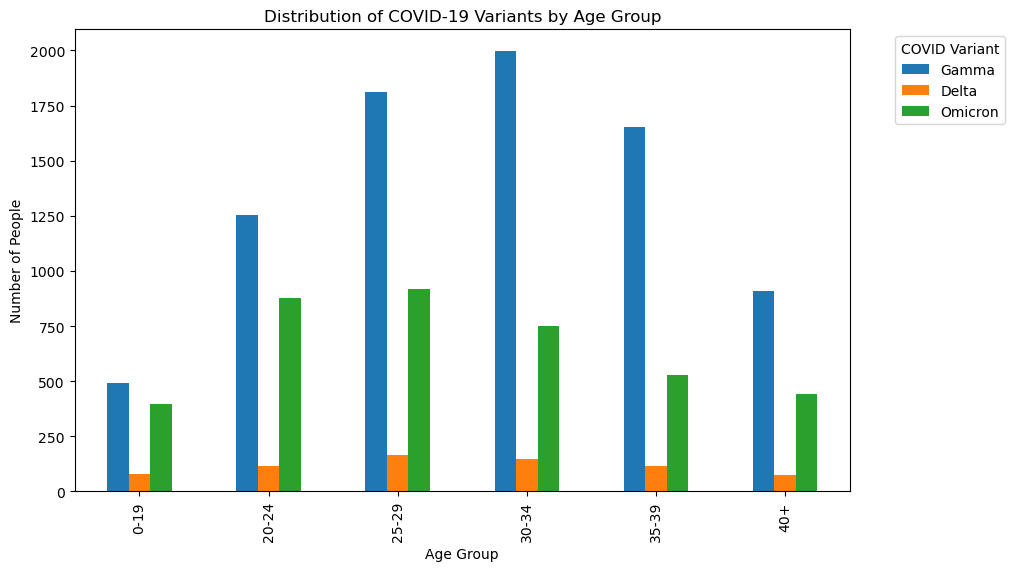

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
0-19,491,6.05%,78,11.22%,398,10.18%,967
20-24,1255,15.46%,117,16.83%,876,22.41%,2248
25-29,1810,22.3%,166,23.88%,918,23.48%,2894
30-34,1996,24.59%,147,21.15%,751,19.21%,2894
35-39,1653,20.37%,115,16.55%,526,13.46%,2294
40+,911,11.22%,72,10.36%,440,11.26%,1423
Total,8116,100.0%,695,100.0%,3909,100.0%,12720


H₀: The two categorical variables have no relationship
p-value : 0.0

Null Hypothesis is rejected.


In [6]:
# Create age groups
bins = [0, 19, 24, 29, 34, 39, float('inf')]

# Add an 'Age_Group' column to the DataFrame
df['Age_Group'] = pd.cut(df['NU_IDADE_N'], bins=bins, labels= FAIXA_ETARIA, right=True)

# Create a DataFrame for plotting
plot_df = pd.DataFrame(index=FAIXA_ETARIA)

# Count the number of people for each variant in each age group
for variant in df['VARIANTE_COVID'].unique():
    variant_counts = df[df['VARIANTE_COVID'] == variant].groupby('Age_Group').size()
    plot_df[variant] = variant_counts

plot_df.rename(columns={1: 'Gamma', 2: 'Delta', 3: 'Omicron'}, inplace=True)

# Plot the grouped bar chart
plot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of COVID-19 Variants by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of People')
plt.legend(title='COVID Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Add 'Total' column
plot_df['Total'] = plot_df.sum(axis=1)

# Add 'Total' row
plot_df.loc['Total'] = plot_df.sum()

percentage_df = plot_df.copy()
# Add percentage columns
for variant in ['Gamma', 'Delta', 'Omicron']:
    percentage_df[variant + '_Percentage'] = (percentage_df[variant] / percentage_df.loc['Total'][variant] * 100).round(2).astype(str) + '%'

column_order = ['Gamma', 'Gamma_Percentage', 'Delta', 'Delta_Percentage', 'Omicron', 'Omicron_Percentage', 'Total']
percentage_df = percentage_df[column_order]
display(percentage_df)

#calculation of p-value : What is the evidence of a correlation between age (in general) and the type of covid variant?

alpha = 0.05
chi_square = 0
columns = plot_df.iloc[:,0:3].columns
rows = plot_df.iloc[0:3].index
for i in columns:
  for j in rows:
    O = plot_df[i][j] #observed value
    E = plot_df[i]['Total'] *plot_df['Total'][j] / plot_df['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E


p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

In [ ]:
def plot_and_test_relationship(df, label, variable, alpha=0.05):
    # Create a DataFrame for plotting
  
    plot_df = pd.DataFrame(index=label)

    # Count the number of people for each variant by disease
    for variant in df['VARIANTE_COVID'].unique():
        variant_counts = df[df['VARIANTE_COVID'] == variant].loc[df[variable] != 'Ignored'].groupby(variable).size()
        plot_df[variant] = variant_counts

    variant_names = {1: 'Gamma', 2: 'Delta', 3: 'Omicron'}
    plot_df.rename(columns=variant_names, inplace=True)

    # Plot the grouped bar chart
    ax = plot_df.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Distribution of COVID-19 Variants by {variable}')
    plt.xlabel(variable)
    plt.ylabel('Number of Samples')
    plt.legend(title='COVID Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
    plt.show()

    # Add 'Total' column
    plot_df['Total'] = plot_df.sum(axis=1)

    # Add 'Total' row
    plot_df.loc['Total'] = plot_df.sum()

    percentage_df = plot_df.copy()
    # Add percentage columns
    for variant in ['Gamma', 'Delta', 'Omicron']:
        percentage_df[variant + '_Percentage'] = (percentage_df[variant] / percentage_df.loc['Total'][variant] * 100).round(2).astype(str) + '%'

    column_order = ['Gamma', 'Gamma_Percentage', 'Delta', 'Delta_Percentage', 'Omicron', 'Omicron_Percentage', 'Total']
    percentage_df = percentage_df[column_order]
    display(percentage_df)

    chi_square = 0
    columns = plot_df.iloc[:,0:3].columns
    rows = plot_df.iloc[0:3].index

    for i in columns:
        for j in rows:
            O = plot_df[i][j]  # observed value
            E = plot_df[i]['Total'] * plot_df['Total'][j] / plot_df['Total']['Total']  # expected frequency
            chi_square += (O - E) ** 2 / E

    p_value = 1 - stats.chi2.cdf(chi_square, (len(rows) - 1) * (len(columns) - 1))

    print(f'H₀: The two categorical variables ({variable} and VARIANTE_COVID) have no relationship')
    print(f'p-value: {p_value}\n')
    conclusion = "Failed to reject the null hypothesis."
    if p_value <= alpha:
        conclusion = "Null Hypothesis is rejected."
    print(conclusion)

Relationship between covid variant and race/color

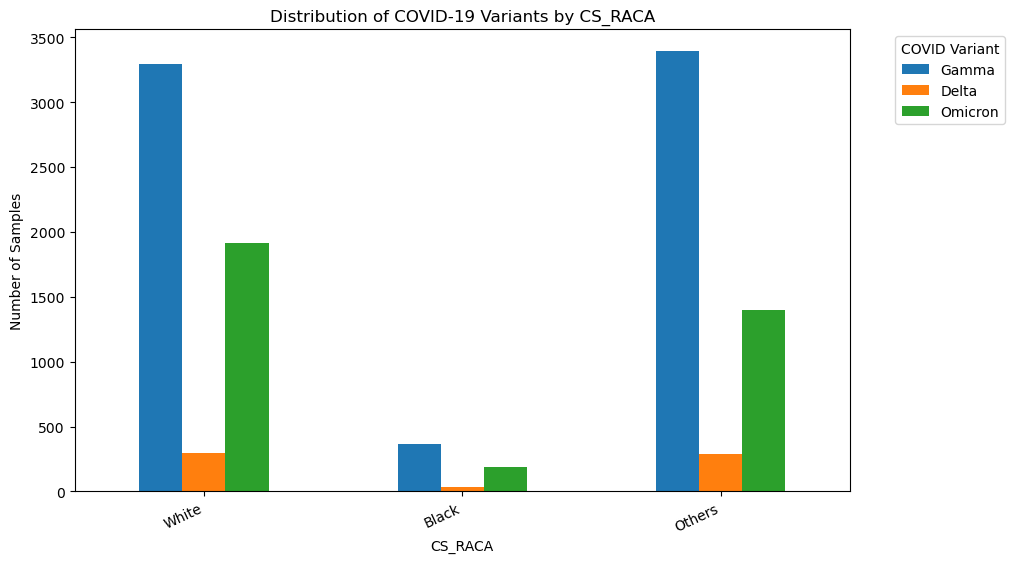

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
White,3297,46.75%,292,47.48%,1918,54.74%,5507
Black,364,5.16%,35,5.69%,185,5.28%,584
Others,3391,48.09%,288,46.83%,1401,39.98%,5080
Total,7052,100.0%,615,100.0%,3504,100.0%,11171


H₀: The two categorical variables (CS_RACA and VARIANTE_COVID) have no relationship
p-value: 2.452482661396971e-13

Null Hypothesis is rejected.


In [34]:
plot_and_test_relationship(df, FAIXA_RACA, 'CS_RACA')

Relationship between the covid variant and schooling

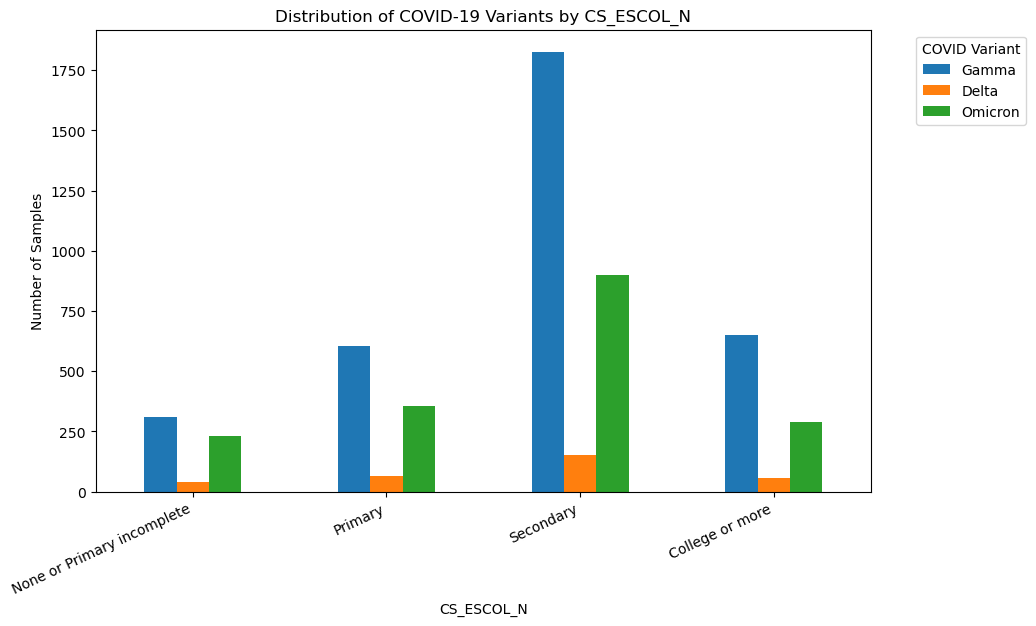

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
None or Primary incomplete,311,9.16%,41,13.23%,229,12.93%,581
Primary,605,17.82%,63,20.32%,354,19.99%,1022
Secondary,1827,53.81%,151,48.71%,899,50.76%,2877
College or more,652,19.2%,55,17.74%,289,16.32%,996
Total,3395,100.0%,310,100.0%,1771,100.0%,5476


H₀: The two categorical variables (CS_ESCOL_N and VARIANTE_COVID) have no relationship
p-value: 7.599431288241032e-05

Null Hypothesis is rejected.


In [33]:
plot_and_test_relationship(df, FAIXA_ESCOLARIDADE, 'CS_ESCOL_N')

Analysis of pregnant and postpartum women

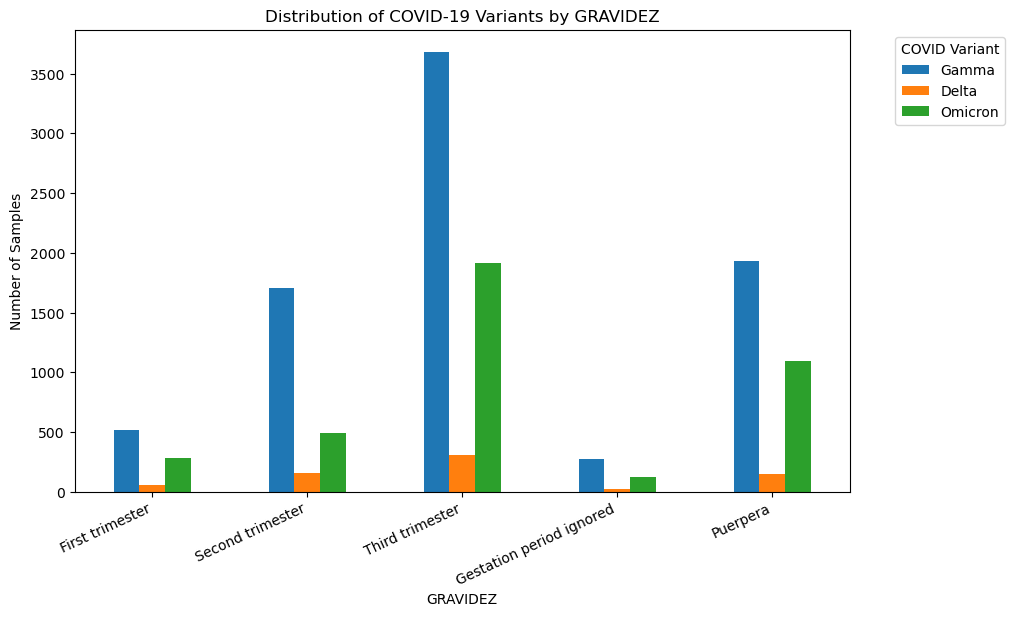

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
First trimester,520,6.41%,55,7.91%,286,7.32%,861
Second trimester,1709,21.05%,162,23.31%,490,12.54%,2361
Third trimester,3682,45.36%,307,44.17%,1912,48.91%,5901
Gestation period ignored,273,3.36%,20,2.88%,128,3.27%,421
Puerpera,1933,23.81%,151,21.73%,1093,27.96%,3177
Total,8117,100.0%,695,100.0%,3909,100.0%,12721


H₀: The two categorical variables (GRAVIDEZ and VARIANTE_COVID) have no relationship
p-value: 0.0

Null Hypothesis is rejected.


In [32]:
plot_and_test_relationship(df, FAIXA_GRAVIDEZ, 'GRAVIDEZ')

Relationship between the covid variant and the vaccine

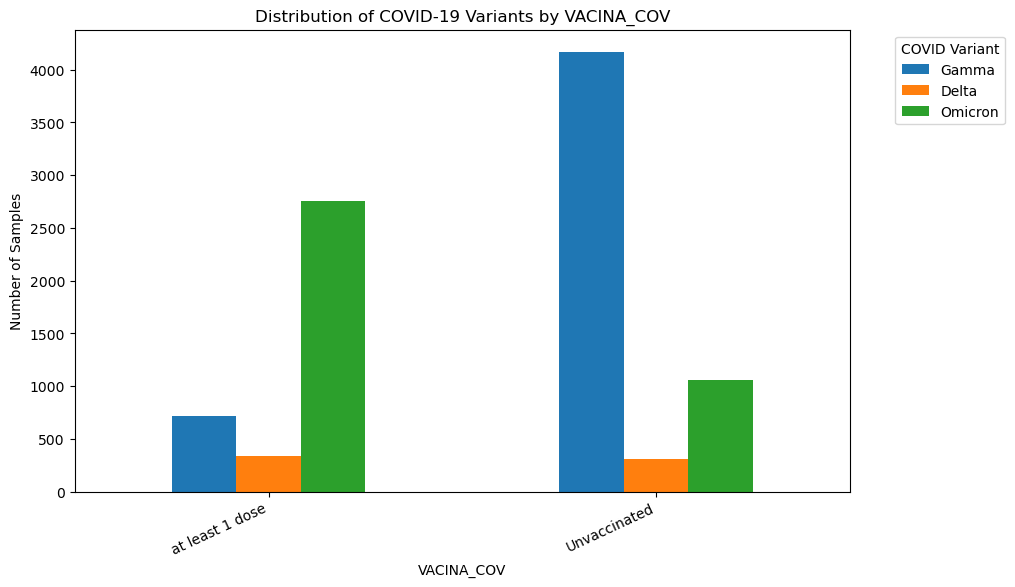

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
at least 1 dose,713,14.6%,337,52.25%,2750,72.22%,3800
Unvaccinated,4170,85.4%,308,47.75%,1058,27.78%,5536
Total,4883,100.0%,645,100.0%,3808,100.0%,9336


H₀: The two categorical variables (VACINA_COV and VARIANTE_COVID) have no relationship
p-value: 0.0

Null Hypothesis is rejected.


In [31]:
plot_and_test_relationship(df, FAIXA_VACINA, 'VACINA_COV')

relationship between region and covid variant

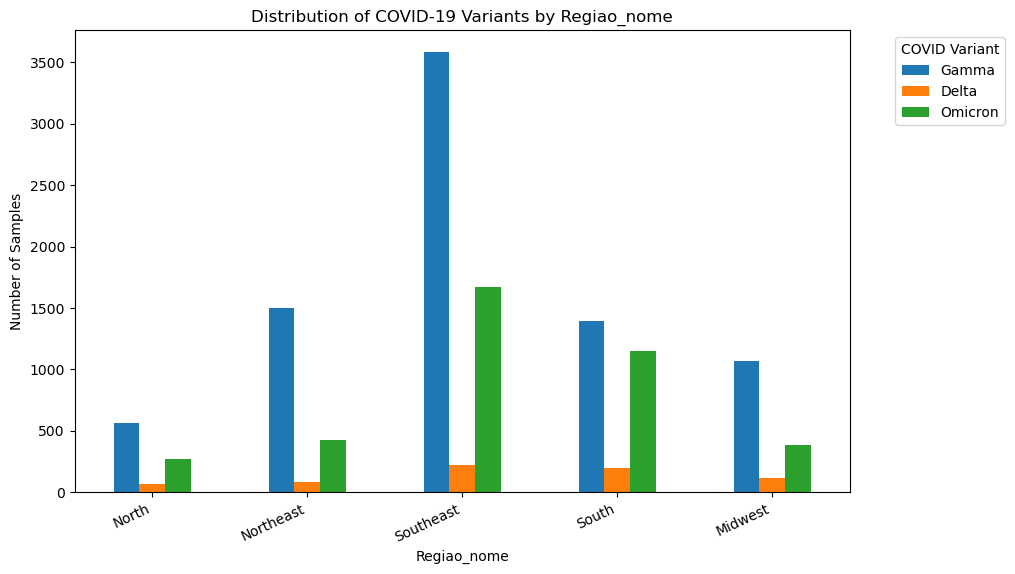

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
North,568,7.0%,69,9.93%,269,6.88%,906
Northeast,1500,18.48%,88,12.66%,426,10.9%,2014
Southeast,3582,44.13%,221,31.8%,1675,42.85%,5478
South,1394,17.17%,197,28.35%,1154,29.52%,2745
Midwest,1073,13.22%,120,17.27%,385,9.85%,1578
Total,8117,100.0%,695,100.0%,3909,100.0%,12721


H₀: The two categorical variables (Regiao_nome and VARIANTE_COVID) have no relationship
p-value: 0.0

Null Hypothesis is rejected.


In [25]:
plot_and_test_relationship(df, FAIXA_REGIAO, 'Regiao_nome')

relationship between chronic cardiovascular disease and covid variant

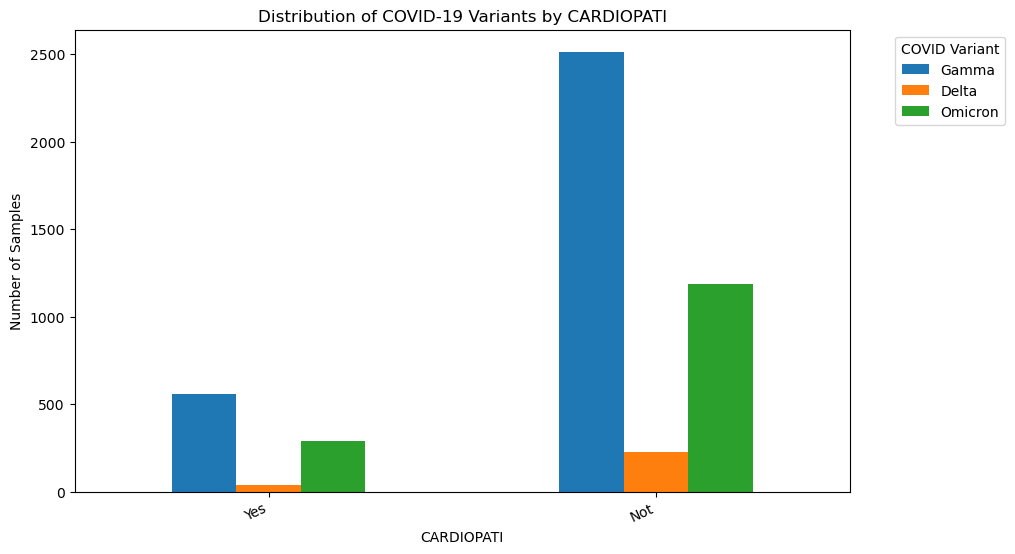

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,559,18.18%,38,14.39%,289,19.61%,886
Not,2515,81.82%,226,85.61%,1185,80.39%,3926
Total,3074,100.0%,264,100.0%,1474,100.0%,4812


H₀: The two categorical variables (CARDIOPATI and VARIANTE_COVID) have no relationship
p-value: 0.3615710229687905

Failed to reject the null hypothesis.


In [26]:
plot_and_test_relationship(df,FAIXA_PADRAO, 'CARDIOPATI')

Relationship between kidney disease and covid variant

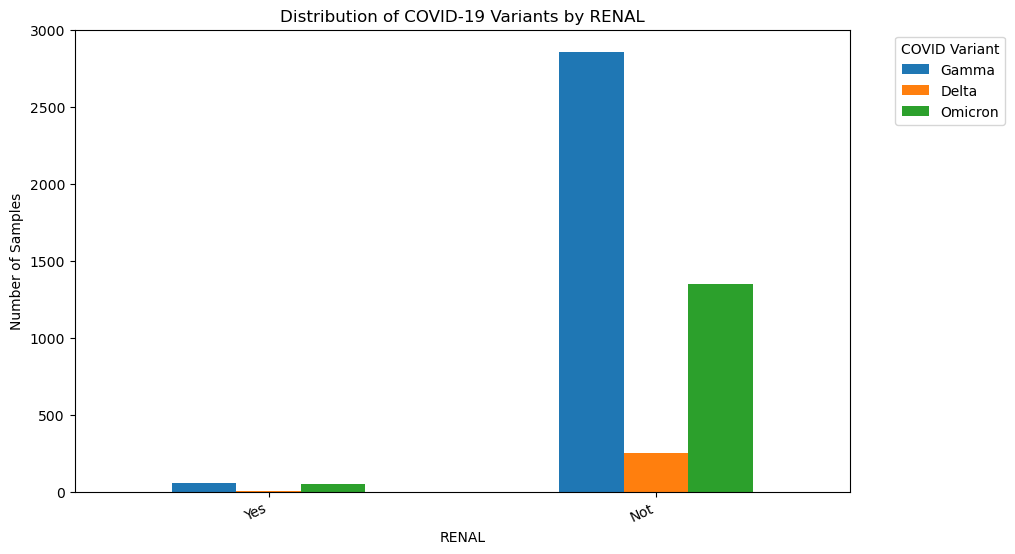

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,57,1.96%,4,1.57%,53,3.77%,114
Not,2858,98.04%,250,98.43%,1351,96.23%,4459
Total,2915,100.0%,254,100.0%,1404,100.0%,4573


H₀: The two categorical variables (RENAL and VARIANTE_COVID) have no relationship
p-value: 0.007827758232712645

Null Hypothesis is rejected.


In [27]:
plot_and_test_relationship(df,FAIXA_PADRAO, 'RENAL')

relationship between asthma and covid variants

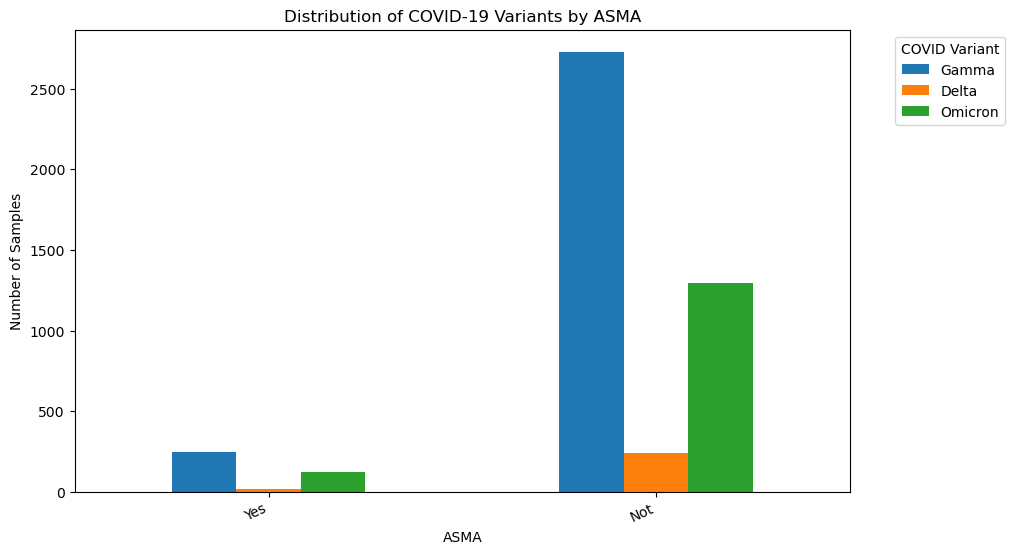

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,244,8.21%,20,7.63%,121,8.56%,385
Not,2729,91.79%,242,92.37%,1293,91.44%,4264
Total,2973,100.0%,262,100.0%,1414,100.0%,4649


H₀: The two categorical variables (ASMA and VARIANTE_COVID) have no relationship
p-value: 0.9892919096900227

Failed to reject the null hypothesis.


In [28]:
plot_and_test_relationship(df, FAIXA_PADRAO, 'ASMA')

relationship between diabetes mellitus and covid variant

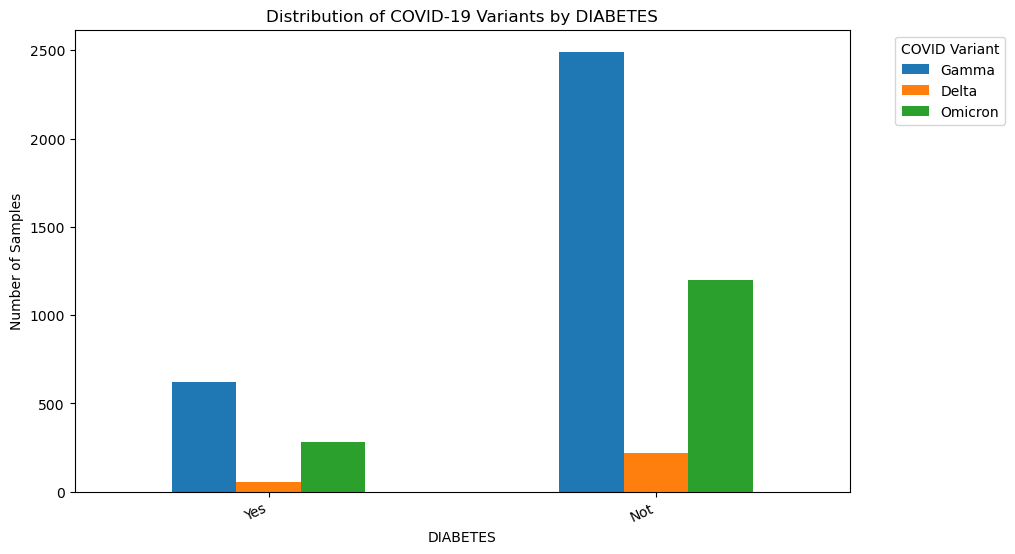

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,619,19.9%,56,20.36%,282,19.02%,957
Not,2492,80.1%,219,79.64%,1201,80.98%,3912
Total,3111,100.0%,275,100.0%,1483,100.0%,4869


H₀: The two categorical variables (DIABETES and VARIANTE_COVID) have no relationship
p-value: 0.9644979128949225

Failed to reject the null hypothesis.


In [29]:
plot_and_test_relationship(df, FAIXA_PADRAO, 'DIABETES')

relationship between other underline medical conditions and covid variant

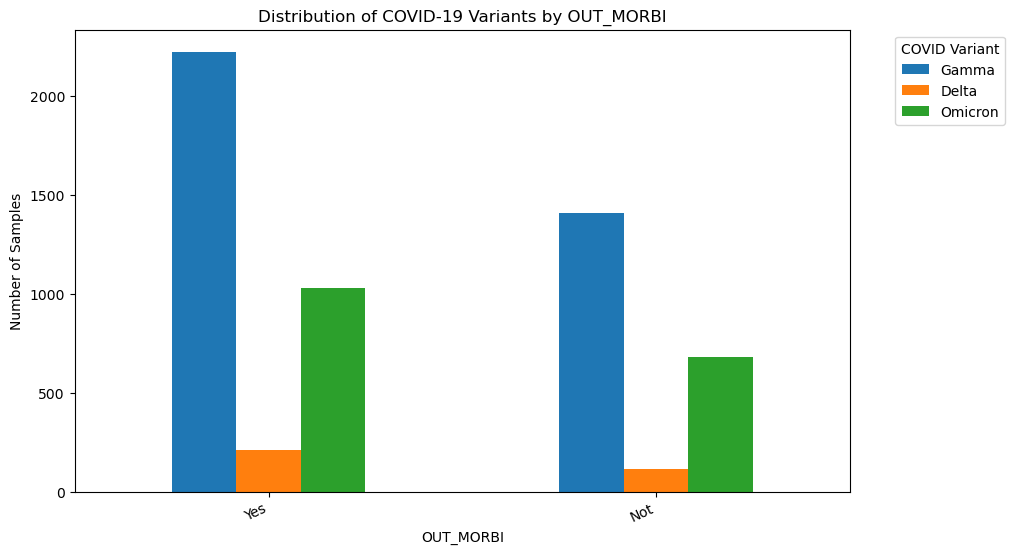

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,2222,61.18%,213,65.14%,1030,60.16%,3465
Not,1410,38.82%,114,34.86%,682,39.84%,2206
Total,3632,100.0%,327,100.0%,1712,100.0%,5671


H₀: The two categorical variables (OUT_MORBI and VARIANTE_COVID) have no relationship
p-value: 0.5774310674529488

Failed to reject the null hypothesis.





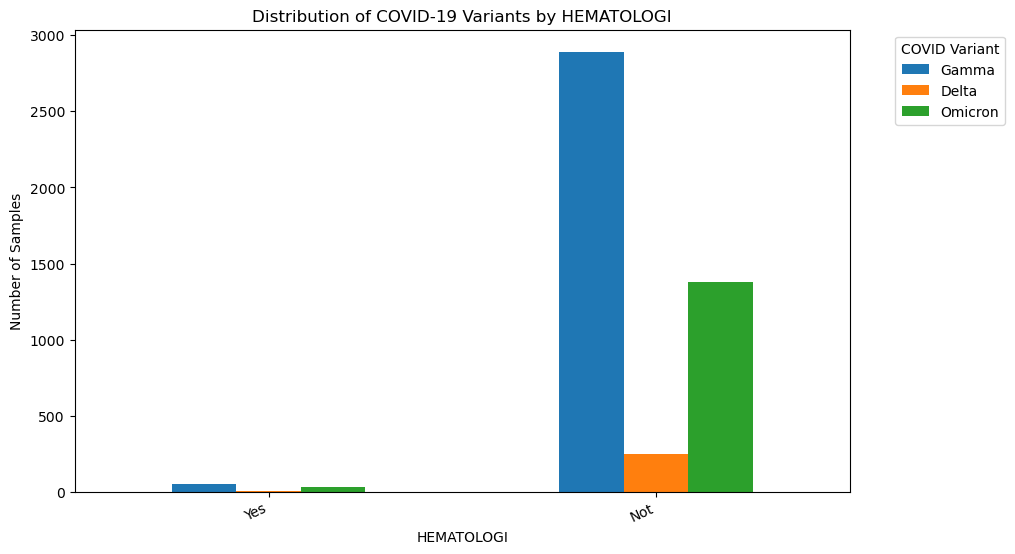

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,51,1.73%,5,1.95%,29,2.06%,85
Not,2892,98.27%,251,98.05%,1377,97.94%,4520
Total,2943,100.0%,256,100.0%,1406,100.0%,4605


H₀: The two categorical variables (HEMATOLOGI and VARIANTE_COVID) have no relationship
p-value: 0.9643926251601277

Failed to reject the null hypothesis.





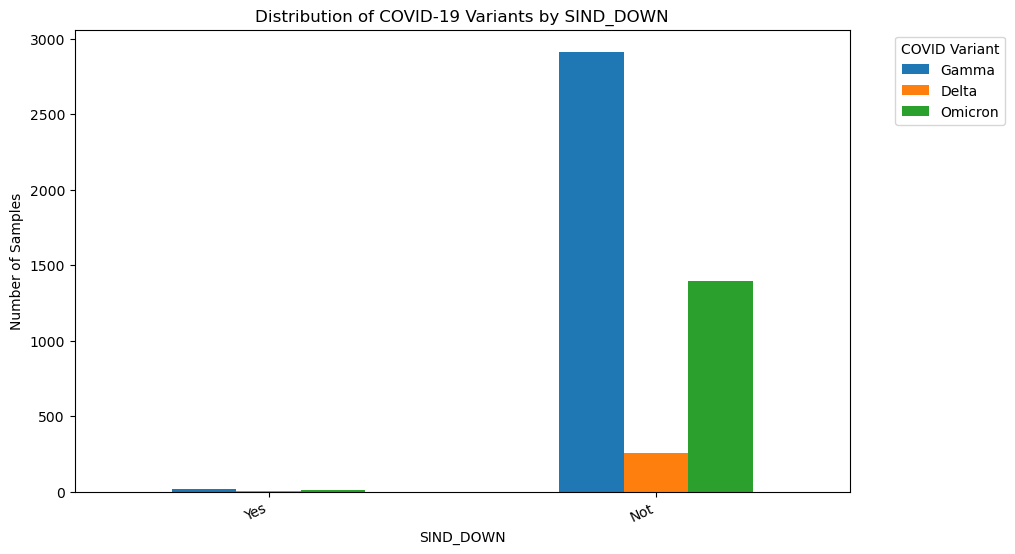

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,15,0.51%,4,1.54%,12,0.85%,31
Not,2914,99.49%,255,98.46%,1397,99.15%,4566
Total,2929,100.0%,259,100.0%,1409,100.0%,4597


H₀: The two categorical variables (SIND_DOWN and VARIANTE_COVID) have no relationship
p-value: 0.31509491489676533

Failed to reject the null hypothesis.





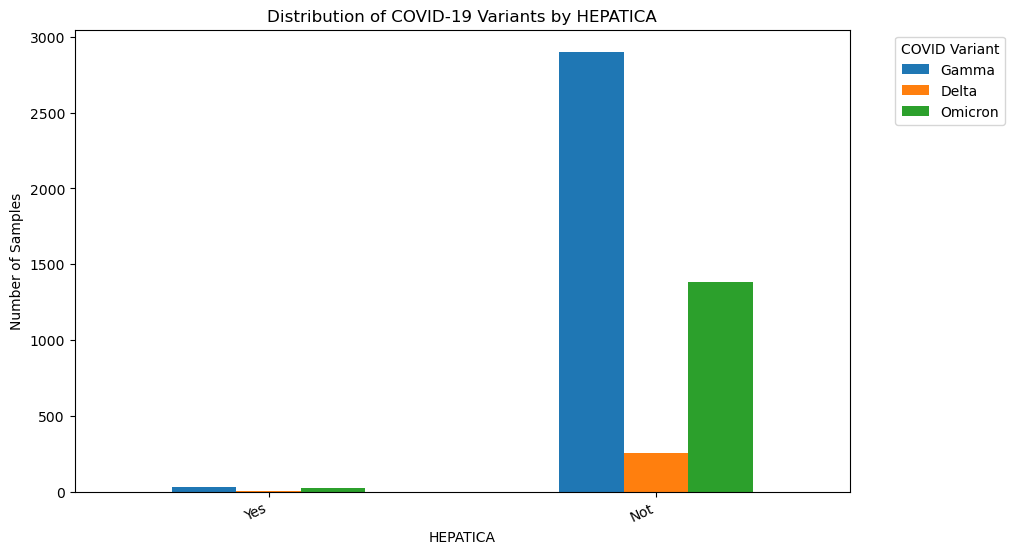

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,28,0.96%,2,0.78%,23,1.64%,53
Not,2902,99.04%,254,99.22%,1380,98.36%,4536
Total,2930,100.0%,256,100.0%,1403,100.0%,4589


H₀: The two categorical variables (HEPATICA and VARIANTE_COVID) have no relationship
p-value: 0.37750235668439946

Failed to reject the null hypothesis.





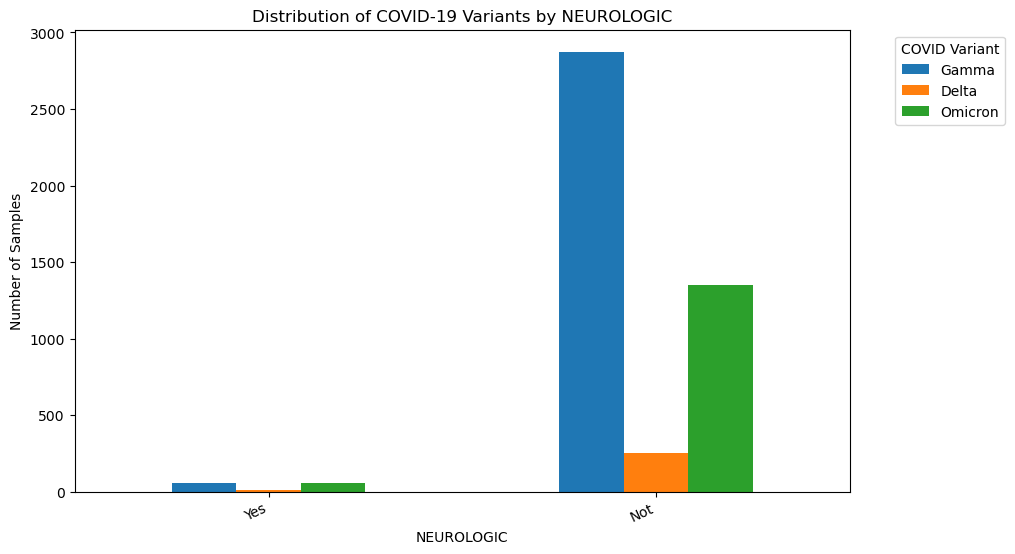

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,57,1.94%,9,3.45%,60,4.26%,126
Not,2874,98.06%,252,96.55%,1348,95.74%,4474
Total,2931,100.0%,261,100.0%,1408,100.0%,4600


H₀: The two categorical variables (NEUROLOGIC and VARIANTE_COVID) have no relationship
p-value: 0.0005769481286874711

Null Hypothesis is rejected.





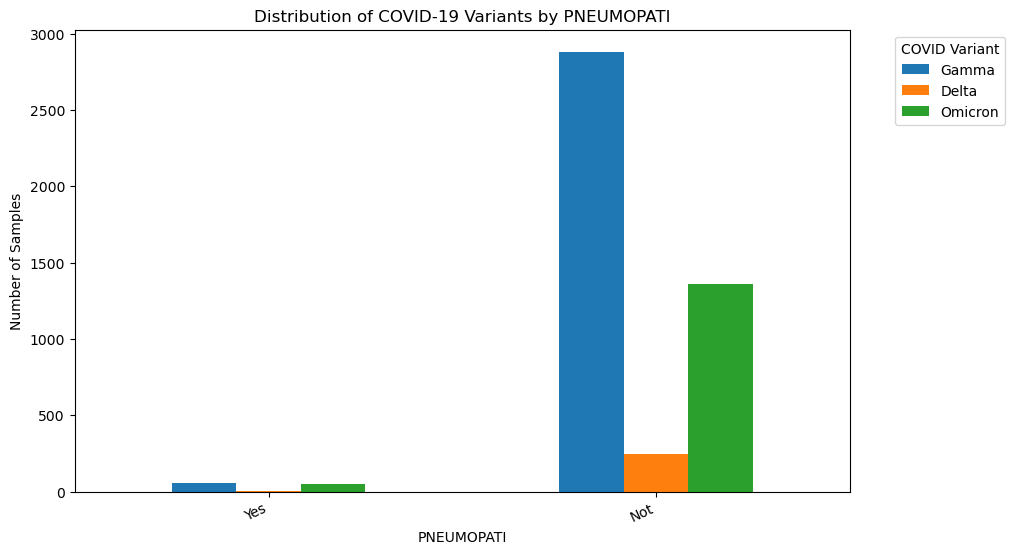

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,54,1.84%,8,3.11%,50,3.54%,112
Not,2882,98.16%,249,96.89%,1361,96.46%,4492
Total,2936,100.0%,257,100.0%,1411,100.0%,4604


H₀: The two categorical variables (PNEUMOPATI and VARIANTE_COVID) have no relationship
p-value: 0.01596609419175188

Null Hypothesis is rejected.





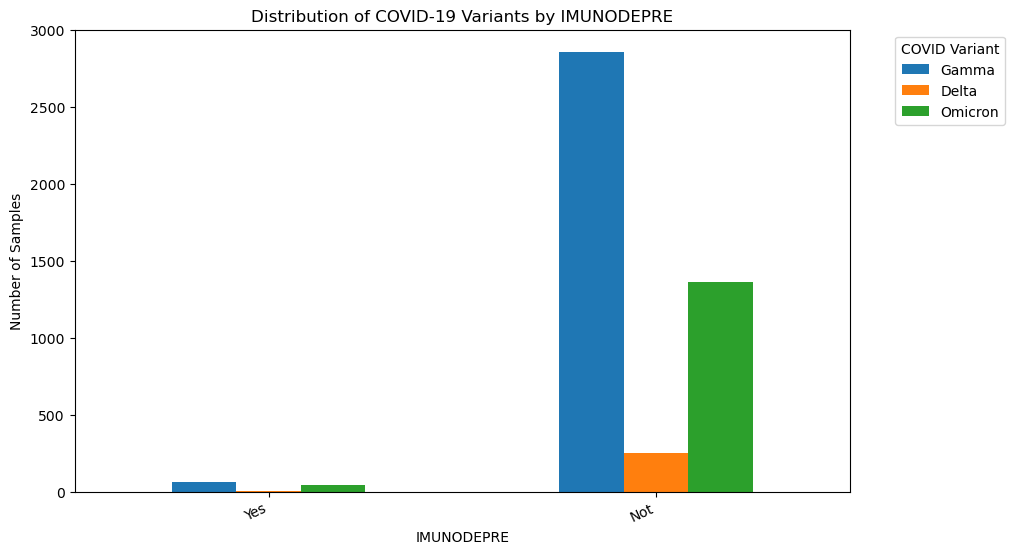

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,64,2.19%,8,3.1%,45,3.2%,117
Not,2859,97.81%,250,96.9%,1362,96.8%,4471
Total,2923,100.0%,258,100.0%,1407,100.0%,4588


H₀: The two categorical variables (IMUNODEPRE and VARIANTE_COVID) have no relationship
p-value: 0.3766885413595187

Failed to reject the null hypothesis.





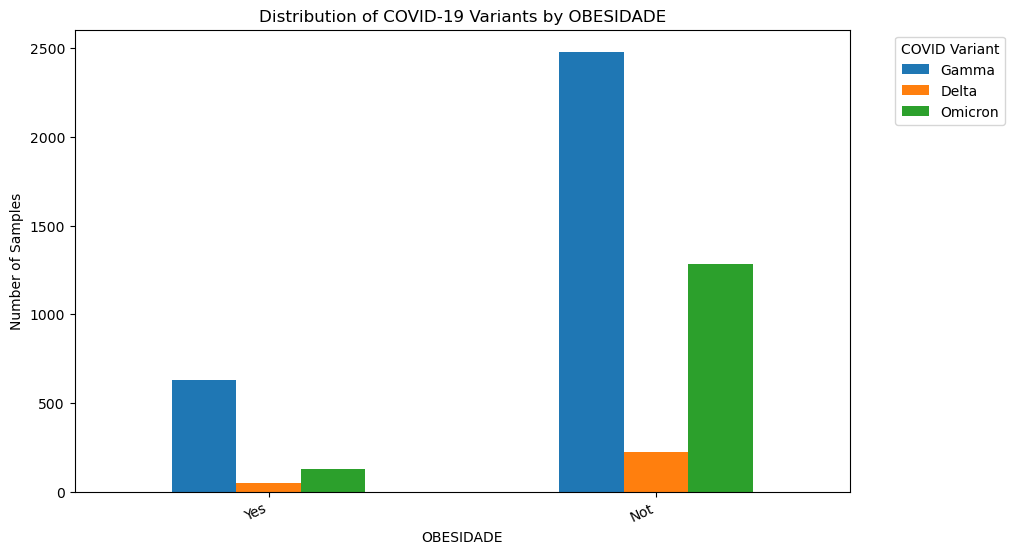

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
Yes,629,20.23%,47,17.41%,126,8.92%,802
Not,2480,79.77%,223,82.59%,1286,91.08%,3989
Total,3109,100.0%,270,100.0%,1412,100.0%,4791


H₀: The two categorical variables (OBESIDADE and VARIANTE_COVID) have no relationship
p-value: 0.0

Null Hypothesis is rejected.





In [30]:
for others in Other_diseases:
    plot_and_test_relationship(df, FAIXA_PADRAO, others)
    print('\n\n')

**Table 1: Sociodemographic and obstetrical characteristics of women with  laboratory confirmed SARS-CoV-2 infection.**

*Notes*


* The dataset does not contain information on parity

* The dataset does not contain information on marital status

* The df['VACINA_COV'] column does not contain the relation: 

    -- complete vaccination : 1

    -- incomplete vaccination : 2  
 
But rather the relation: 

-- at least 1 dose : 1  

-- no dose :2 

 
 Thus, to determine whether the vaccination was complete (2 doses or more), we need to look at the dates of the doses, but these variables have many NaNs

